In [18]:
# Colab: install any missing packages (scikit-learn, openpyxl usually preinstalled)
!pip install --quiet openpyxl

# Mount Google Drive (recommended for large dataset and saving outputs)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [20]:
# Option A: if Excel in Drive
path = "/content/drive/MyDrive/online_retail_II.xlsx"   # change to your path
df = pd.read_excel(path, engine="openpyxl")

# Option B: if CSV uploaded to Colab
# from google.colab import files
# uploaded = files.upload()   # then use filename from uploaded
# df = pd.read_csv("yourfile.csv")

print("Loaded", df.shape)
df.head()


Loaded (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [21]:
# adapt column names exactly as in your dataset
df = df.dropna(subset=["Customer ID"])
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[~df["Invoice"].astype(str).str.startswith("C")]
print("After cleaning:", df.shape)


After cleaning: (407664, 8)


In [22]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
latest_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,
    "Invoice": "nunique",
    "TotalPrice": "sum"
}).reset_index()
rfm.columns = ["Customer ID","Recency","Frequency","Monetary"]
rfm = rfm[rfm["Monetary"] > 0].reset_index(drop=True)
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [23]:
features = rfm[["Recency","Frequency","Monetary"]]
features_log = np.log1p(features)

def remove_iqr_outliers(df, cols, factor=1.5):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

features_log_clean = remove_iqr_outliers(features_log, features_log.columns)
mask = features_log.isin(features_log_clean).all(axis=1)
rfm_clean = rfm[mask].reset_index(drop=True)
features_clean = features_log[mask].reset_index(drop=True)
print("After outlier removal:", rfm_clean.shape)


After outlier removal: (4235, 4)


In [24]:
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_clean)


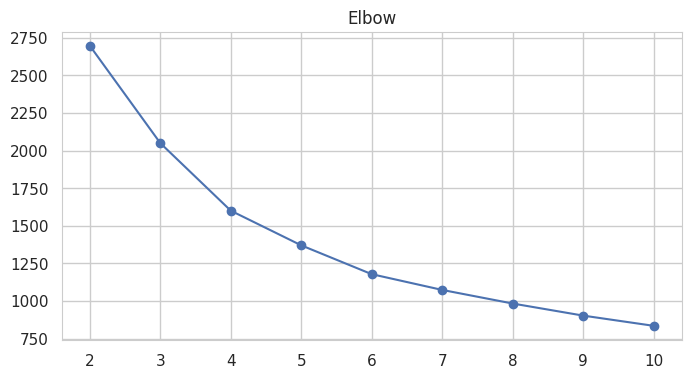

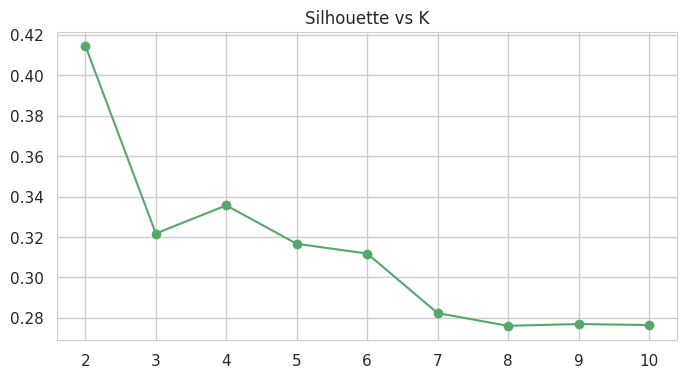

Optimal K: 2 silhouette: 0.41455362768623477


In [25]:
import matplotlib.pyplot as plt
sil_scores = []
inertias = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=15, max_iter=500, random_state=42)
    labels = km.fit_predict(features_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(features_scaled, labels))

plt.figure(figsize=(8,4)); plt.plot(K_range, inertias,'bo-'); plt.title("Elbow"); plt.show()
plt.figure(figsize=(8,4)); plt.plot(K_range, sil_scores,'go-'); plt.title("Silhouette vs K"); plt.show()

optimal_k = K_range[np.argmax(sil_scores)]
print("Optimal K:", optimal_k, "silhouette:", max(sil_scores))


In [26]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=15, max_iter=500, random_state=42)
rfm_clean["Cluster"] = kmeans.fit_predict(features_scaled)
sil_km = silhouette_score(features_scaled, rfm_clean["Cluster"])
print("KMeans silhouette:", sil_km)

gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42, max_iter=500)
rfm_clean["GMM_Cluster"] = gmm.fit_predict(features_scaled)
sil_gmm = silhouette_score(features_scaled, rfm_clean["GMM_Cluster"])
print("GMM silhouette:", sil_gmm)

if sil_gmm > sil_km:
    rfm_clean["Final_Cluster"] = rfm_clean["GMM_Cluster"]
    model_name = "GMM"
    best_sil = sil_gmm
else:
    rfm_clean["Final_Cluster"] = rfm_clean["Cluster"]
    model_name = "KMeans"
    best_sil = sil_km
print("Selected model:", model_name, best_sil)


KMeans silhouette: 0.41455362768623477
GMM silhouette: 0.29121495374879997
Selected model: KMeans 0.41455362768623477


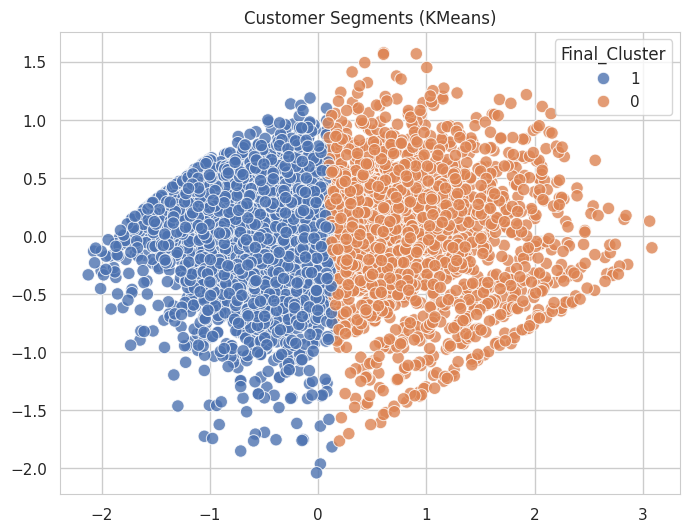

In [27]:
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(features_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=rfm_clean["Final_Cluster"].astype(str), s=80, alpha=0.8)
plt.title(f"Customer Segments ({model_name})")
plt.show()


In [28]:
profile = rfm_clean.groupby("Final_Cluster").agg({
    "Recency":"mean","Frequency":"mean","Monetary":"mean","Customer ID":"count"
}).round(2).rename(columns={"Customer ID":"Count"})
print(profile)

# Save outputs to Drive
rfm_clean.to_csv("/content/drive/MyDrive/customer_segments_improved.csv", index=False)
profile.to_csv("/content/drive/MyDrive/cluster_profile.csv")
print("Saved to Drive")


               Recency  Frequency  Monetary  Count
Final_Cluster                                     
0                34.33       6.65   2746.01   1818
1               134.98       1.63    438.72   2417
Saved to Drive


In [29]:
# run this first to inspect files
from pathlib import Path
PROJECT_DIR = Path("/content/drive/MyDrive/ML_Project")   # adjust if different
for sub in ["data","figures","reports","notebooks","src","logs"]:
    p = PROJECT_DIR / sub
    print(f"\n{sub} -> {p}")
    if p.exists():
        files = list(p.glob("*"))
        if not files:
            print("  (empty)")
        else:
            for f in files:
                print("  ", f.name)
    else:
        print("  (folder missing)")



data -> /content/drive/MyDrive/ML_Project/data
   online_retail_II.xlsx
   rfm_raw_auto.csv
   rfm_with_clusters.csv
   rfm_with_clusters_full.csv
   cluster_profile.csv

figures -> /content/drive/MyDrive/ML_Project/figures
   silhouette_vs_k.png
   elbow_inertia.png
   cluster_counts.png
   pca_clusters.png
   box_frequency_by_cluster.png
   box_recency_by_cluster.png
   cluster_monetary_mean.png
   box_monetary_by_cluster.png
   cluster_profile_radar.png

reports -> /content/drive/MyDrive/ML_Project/reports
   cluster_report.md
   summary.json
   cluster_report.html

notebooks -> /content/drive/MyDrive/ML_Project/notebooks
   MarketSegmentation.ipynb

src -> /content/drive/MyDrive/ML_Project/src
   .ipynb_checkpoints
   main.py

logs -> /content/drive/MyDrive/ML_Project/logs
  (empty)


In [30]:
# ----------------- RUN FULL PIPELINE (auto-detect dataset) -----------------
from pathlib import Path
import pandas as pd, numpy as np, json, os, datetime
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1) Mount Drive (uncomment if not mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 2) Set your project dir (change if needed)
PROJECT_DIR = Path("/content/drive/MyDrive/ML_Project")   # <-- edit this if your folder differs
for d in ["data","figures","reports","notebooks","src","logs"]:
    (PROJECT_DIR / d).mkdir(parents=True, exist_ok=True)

DATA = PROJECT_DIR / "data"
FIGS = PROJECT_DIR / "figures"
REPORTS = PROJECT_DIR / "reports"

print("PROJECT_DIR:", PROJECT_DIR)
print("Files in data/:", list(p.name for p in DATA.glob("*")))

# 3) Auto-detect a dataset file (prefer excel then csv)
candidates = sorted([p for p in DATA.glob("*") if p.suffix.lower() in [".csv",".xls",".xlsx"]],
                    key=lambda p: p.stat().st_size if p.exists() else 0, reverse=True)
if not candidates:
    raise FileNotFoundError(f"No dataset files found in {DATA}. Upload your dataset (CSV or XLSX) to that folder and re-run.")
data_file = candidates[0]
print("Using dataset:", data_file.name)

# 4) Load the dataset robustly
def load_any(path):
    if path.suffix.lower() in [".xls", ".xlsx"]:
        return pd.read_excel(path, engine="openpyxl")
    else:
        return pd.read_csv(path, low_memory=False)
df = load_any(data_file)
print("Loaded shape:", df.shape)
display(df.head(3))

# 5) Try to detect column names for invoice/customer/qty/price/date
col_map = {}
lower_cols = {c.lower(): c for c in df.columns}
def find_one(options):
    for o in options:
        if o.lower() in lower_cols:
            return lower_cols[o.lower()]
    return None

col_map['invoice'] = find_one(["Invoice","InvoiceNo","InvoiceNo.","invoice"])
col_map['cust']    = find_one(["Customer ID","CustomerID","Customer","customer id"])
col_map['date']    = find_one(["InvoiceDate","Invoice Date","Date","date","invoice date"])
col_map['qty']     = find_one(["Quantity","Qty","quantity"])
col_map['price']   = find_one(["Price","UnitPrice","Unit Price","unit price","unitprice","price"])

print("Detected columns:", col_map)

# 6) Basic cleaning and RFM computation
if col_map['date']:
    df[col_map['date']] = pd.to_datetime(df[col_map['date']], errors='coerce', dayfirst=True)
else:
    raise RuntimeError("No date column detected. Rename dataset columns or pass correct column names in earlier cells.")

# drop rows with no customer or date
if col_map['cust']:
    df = df.dropna(subset=[col_map['cust']])
else:
    raise RuntimeError("No customer ID column detected. Rename dataset columns appropriately.")

# filter positive qty/price if present
if col_map['qty']:
    df = df[df[col_map['qty']].fillna(0) > 0]
if col_map['price']:
    df = df[df[col_map['price']].fillna(0) > 0]

# total price if possible
if col_map['qty'] and col_map['price']:
    df['TotalPrice'] = df[col_map['qty']] * df[col_map['price']]
else:
    df['TotalPrice'] = 0.0

latest = df[col_map['date']].max() + pd.Timedelta(days=1)
# invoice aggregator: if invoice column exists use it else use index
inv_col = col_map['invoice'] if col_map['invoice'] else df.columns[0]
rfm = df.groupby(col_map['cust']).agg({
    col_map['date']: lambda x: (latest - x.max()).days,
    inv_col: 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = [col_map['cust'],'Recency','Frequency','Monetary']
rfm = rfm[rfm['Monetary'] > 0].reset_index(drop=True)
print("RFM computed: customers =", rfm.shape[0])
display(rfm.head())

# save raw rfm
rfm.to_csv(DATA / "rfm_raw_auto.csv", index=False)

# 7) transform, outlier removal (IQR on log1p)
feat = np.log1p(rfm[['Recency','Frequency','Monetary']])
def iqr_keep(df_in, factor=1.5):
    mask = pd.Series(True, index=df_in.index)
    for c in df_in.columns:
        Q1 = df_in[c].quantile(0.25)
        Q3 = df_in[c].quantile(0.75)
        IQR = Q3 - Q1
        mask &= (df_in[c] >= (Q1 - factor*IQR)) & (df_in[c] <= (Q3 + factor*IQR))
    return mask
mask = iqr_keep(feat)
rfm_clean = rfm.loc[mask].reset_index(drop=True)
feat_clean = np.log1p(rfm_clean[['Recency','Frequency','Monetary']])
print("After outlier removal:", rfm_clean.shape[0])

# 8) scaling
scaler = RobustScaler()
features_scaled = scaler.fit_transform(feat_clean)

# 9) determine K (2..10) using silhouette
Ks = list(range(2,11))
sil_scores = []
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=12, random_state=42).fit(features_scaled)
    sil_scores.append(silhouette_score(features_scaled, km.labels_))
    inertias.append(km.inertia_)

best_k = Ks[int(np.argmax(sil_scores))]
print("Best K by silhouette:", best_k, "score:", max(sil_scores))

# save elbow & silhouette plots
plt.figure(figsize=(6,3)); plt.plot(Ks,inertias,'o-'); plt.title("Elbow - inertia"); plt.xlabel("K"); plt.savefig(FIGS/"elbow_inertia.png", bbox_inches='tight', dpi=150); plt.close()
plt.figure(figsize=(6,3)); plt.plot(Ks,sil_scores,'o-'); plt.title("Silhouette vs K"); plt.xlabel("K"); plt.savefig(FIGS/"silhouette_vs_k.png", bbox_inches='tight', dpi=150); plt.close()

# 10) Fit KMeans & GMM with best_k and choose better by silhouette
km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(features_scaled)
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42).fit(features_scaled)
sil_km = silhouette_score(features_scaled, km.labels_)
sil_gmm = silhouette_score(features_scaled, gmm.predict(features_scaled))
model_choice = 'GMM' if sil_gmm > sil_km else 'KMeans'
print(f"Silhouette KMeans={sil_km:.4f}, GMM={sil_gmm:.4f} -> chosen {model_choice}")

# attach cluster labels to rfm_clean
rfm_clean = rfm_clean.reset_index(drop=True)
rfm_clean['KMeansCluster'] = km.predict(features_scaled)
rfm_clean['GMMCluster'] = gmm.predict(features_scaled)
rfm_clean['FinalCluster'] = rfm_clean['GMMCluster'] if model_choice=='GMM' else rfm_clean['KMeansCluster']

# save outputs
rfm_clean.to_csv(DATA / "rfm_with_clusters.csv", index=False)
rfm_clean.to_csv(DATA / "rfm_with_clusters_full.csv", index=False)

# 11) PCA scatter and profile + figures
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(features_scaled)
proj_df = pd.DataFrame(proj, columns=['PC1','PC2'])
proj_df['Cluster'] = rfm_clean['FinalCluster'].astype(str).values
plt.figure(figsize=(7,5)); sns.scatterplot(data=proj_df, x='PC1', y='PC2', hue='Cluster', s=60, alpha=0.8); plt.title("PCA 2D clusters"); plt.savefig(FIGS/"pca_clusters.png", bbox_inches='tight', dpi=150); plt.close()

profile = rfm_clean.groupby('FinalCluster').agg({'Recency':'mean','Frequency':'mean','Monetary':'mean','Customer ID':'count'}).rename(columns={'Customer ID':'Count'}).round(2)
profile.to_csv(DATA / "cluster_profile.csv")

# profile plots
profile_reset = profile.reset_index()
plt.figure(figsize=(6,4)); sns.barplot(x='FinalCluster', y='Count', data=profile_reset); plt.title("Customers per cluster"); plt.savefig(FIGS/"cluster_counts.png", bbox_inches='tight', dpi=150); plt.close()
plt.figure(figsize=(6,4)); sns.barplot(x='FinalCluster', y='Monetary', data=profile_reset); plt.title("Mean Monetary per cluster"); plt.savefig(FIGS/"cluster_monetary_mean.png", bbox_inches='tight', dpi=150); plt.close()

# boxplots
for c in ['Recency','Frequency','Monetary']:
    plt.figure(figsize=(7,4)); sns.boxplot(x=rfm_clean['FinalCluster'].astype(str), y=rfm_clean[c]); plt.title(f"{c} by cluster"); plt.savefig(FIGS/f"box_{c.lower()}_by_cluster.png", bbox_inches='tight', dpi=150); plt.close()

# radar plot
try:
    features = ['Recency','Frequency','Monetary']
    dfp = profile[features]
    dfn = (dfp - dfp.min()) / (dfp.max() - dfp.min())
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    import matplotlib
    matplotlib.rcParams['axes.linewidth'] = 0.8
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    for idx, row in dfn.iterrows():
        vals = row.tolist(); vals += vals[:1]
        ax.fill(angles, vals, alpha=0.15); ax.plot(angles, vals, label=f"Cluster {idx}")
    ax.set_thetagrids(np.degrees(angles[:-1]), features)
    plt.legend(bbox_to_anchor=(1.05,1.05))
    plt.title("Cluster profile (normalized radar)")
    plt.savefig(FIGS/"cluster_profile_radar.png", bbox_inches='tight', dpi=150); plt.close()
except Exception as e:
    print("Radar plot skipped:", e)

# 12) Save summary json and simple HTML report fragment
summary = {
    'run_time': datetime.datetime.now().isoformat(),
    'input_file': data_file.name,
    'n_records_raw': int(df.shape[0]),
    'n_customers_raw': int(rfm.shape[0]),
    'n_customers_clean': int(rfm_clean.shape[0]),
    'best_k': int(best_k),
    'sil_kmeans': float(sil_km),
    'sil_gmm': float(sil_gmm),
    'chosen_model': model_choice
}
with open(REPORTS / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

md = f"""# Auto-generated cluster report
Input file: {data_file.name}
Run time: {summary['run_time']}

Cluster profile (saved at data/cluster_profile.csv):

{profile.to_csv()}

Figures saved in figures/ folder.
"""
(REPORTS / "cluster_report.md").write_text(md)
# attempt html
try:
    import markdown
    html = markdown.markdown(md)
    (REPORTS / "cluster_report.html").write_text(f"<html><body>{html}</body></html>")
except Exception:
    pass

print("Done. Outputs written to:")
print(" -", DATA)
print(" -", FIGS)
print(" -", REPORTS)
print("\nFiles created (examples):")
print(" ", (DATA/"rfm_with_clusters.csv").exists(), "rfm_with_clusters.csv")
print(" ", (DATA/"cluster_profile.csv").exists(), "cluster_profile.csv")
print("Open the report at:", REPORTS / "cluster_report.md")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_DIR: /content/drive/MyDrive/ML_Project
Files in data/: ['online_retail_II.xlsx', 'rfm_raw_auto.csv', 'rfm_with_clusters.csv', 'rfm_with_clusters_full.csv', 'cluster_profile.csv']
Using dataset: online_retail_II.xlsx
Loaded shape: (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


Detected columns: {'invoice': 'Invoice', 'cust': 'Customer ID', 'date': 'InvoiceDate', 'qty': 'Quantity', 'price': 'Price'}
RFM computed: customers = 4312


,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


After outlier removal: 4239
Best K by silhouette: 2 score: 0.4150151025453599
Silhouette KMeans=0.4150, GMM=0.2909 -> chosen KMeans
Done. Outputs written to:
 - /content/drive/MyDrive/ML_Project/data
 - /content/drive/MyDrive/ML_Project/figures
 - /content/drive/MyDrive/ML_Project/reports

Files created (examples):
  True rfm_with_clusters.csv
  True cluster_profile.csv
Open the report at: /content/drive/MyDrive/ML_Project/reports/cluster_report.md


In [34]:
# ===============================================
# 1. Create requirements.txt
# ===============================================
requirements_content = """
numpy
pandas
scikit-learn
matplotlib
seaborn
"""

with open("requirements.txt", "w") as f:
    f.write(requirements_content)

print("📦 requirements.txt created")


# ===============================================
# 2. Create project folders (if not existing)
# ===============================================
import os

os.makedirs("src", exist_ok=True)
print("📁 'src/' folder ready")


# ===============================================
# 3. Create run.sh (Linux script for Colab)
# ===============================================
run_sh_content = """#!/bin/bash
echo "Installing requirements..."
pip install -r requirements.txt

echo "Running main.py..."
python src/main.py
"""

with open("run.sh", "w") as f:
    f.write(run_sh_content)

print("🚀 run.sh created")


# ===============================================
# 4. Make run.sh executable
# ===============================================
!chmod +x run.sh
print("🔑 Permission set: run.sh is now executable")


# ===============================================
# 5. Display final project structure
# ===============================================
print("\n📂 Project structure:")
!ls -R .


📦 requirements.txt created
📁 'src/' folder ready
🚀 run.sh created

🔑 Permission set: run.sh is now executable

📂 Project structure:

.:
data  figures  logs  notebooks	reports  requirements.txt  run.sh  src

./data:
cluster_profile.csv    rfm_raw_auto.csv       rfm_with_clusters_full.csv
online_retail_II.xlsx  rfm_with_clusters.csv

./figures:
box_frequency_by_cluster.png  cluster_counts.png	 elbow_inertia.png
box_monetary_by_cluster.png   cluster_monetary_mean.png  pca_clusters.png
box_recency_by_cluster.png    cluster_profile_radar.png  silhouette_vs_k.png

./logs:

./notebooks:
MarketSegmentation.ipynb

./reports:
cluster_report.html  cluster_report.md	summary.json

./src:
main.py
